In [1]:
%matplotlib nbagg
import scipy.io as sio
import scipy.signal as sg
import numpy as np
import pandas as pd
import datetime as dt
from Tkinter import Tk
from tkFileDialog import askopenfilename
from matplotlib.pyplot import *
from matplotlib.dates import num2date, date2num, hours, DateFormatter

### Defining paths and selecting files for Amplitude (0) and Phase (1)

In [ ]:
# If you want to use interactive window 
Tk().withdraw()
path0     = str(askopenfilename())
path1     = str(askopenfilename())

filename0 = path0[-26:]
filename1 = path1[-26:]

mat_contents0 = sio.loadmat(path0)
mat_contents1 = sio.loadmat(path1)

In [2]:
# If you don't want to use interactive window
# Use simply the path as string
path0     = 'C:\Users\ecorr\Dropbox\Dados-AWESOME-Antonio\Fev2010/B1100223000500NPM_003A.mat'
path1     = 'C:\Users\ecorr\Dropbox\Dados-AWESOME-Antonio\Fev2010/B1100223000500NPM_003B.mat'

filename0 = path0[-26:]
filename1 = path1[-26:]

mat_contents0 = sio.loadmat(path0)
mat_contents1 = sio.loadmat(path1)

In [ ]:
# Print the mat file content
#for i in mat_contents0:
#    print i

### Defining variables for Amplitude (0) and Phase (1)

In [3]:
channel_sampling_freq0 = mat_contents0['Fs']
data_amp               = mat_contents0['data']
callsign0              = filename0[14:17]
adc_channel0           = mat_contents0['adc_channel_number']
start_day0             = mat_contents0['start_day']
start_hour0            = mat_contents0['start_hour']
start_minute0          = mat_contents0['start_minute']
start_month0           = mat_contents0['start_month']
start_second0          = mat_contents0['start_second']
start_year0            = mat_contents0['start_year']
station_name0          = mat_contents0['station_name']
startdate0             = dt.datetime(start_year0,start_month0,start_day0,start_hour0,start_minute0,start_second0)
time0                  = pd.date_range(str(startdate0), periods=len(data_amp),
                                       freq=str(channel_sampling_freq0)[2:3]+' s')

In [4]:
channel_sampling_freq1 = mat_contents1['Fs']
data_phase             = mat_contents1['data']
callsign1              = filename1[14:17]
adc_channel1           = mat_contents1['adc_channel_number']
start_day1             = mat_contents1['start_day']
start_hour1            = mat_contents1['start_hour']
start_minute1          = mat_contents1['start_minute']
start_month1           = mat_contents1['start_month']
start_second1          = mat_contents1['start_second']
start_year1            = mat_contents1['start_year']
station_name1          = mat_contents1['station_name']
startdate1             = dt.datetime(start_year1,start_month1,start_day1,start_hour1,start_minute1,start_second1)
time1                  = pd.date_range(str(startdate1), periods=len(data_phase),
                                       freq=str(channel_sampling_freq1)[2:3]+' s')

### Correcting data phase

In [8]:
AveragingLengthAmp = 1    # dados a cada 10seg
AveragingLengthPhase = 1
PhaseFixLength = 60
averaging_length = channel_sampling_freq1*PhaseFixLength

def fix_phasedata180(data_phase, averaging_length):
    data_phase = np.reshape(data_phase,len(data_phase))
    x = np.exp(1j*data_phase*2./180.*np.pi)
    N = float(averaging_length)
    b, a = sg.butter(1, 0.021)
    y = sg.filtfilt(b, a, x)
    output_phase = data_phase - np.array(map(round,((data_phase/180*np.pi-np.unwrap(np.angle(y))/2)%(2*np.pi))*180/np.pi/180))*180
    temp = output_phase[0]%90
    output_phase = output_phase-output_phase[0]+temp
    s = output_phase[output_phase >= 180]
    for s in range(len(output_phase)):
        output_phase[s] = output_phase[s]-360
    return output_phase

def fix_phasedata90(data_phase, averaging_length):
    data_phase = np.reshape(data_phase,len(data_phase))
    x = np.exp(1j*data_phase*4./180.*np.pi)
    N = float(averaging_length)
    b, a = sg.butter(1, 0.021)
    y = sg.filtfilt(b, a, x)
    output_phase = data_phase - np.array(map(round,((data_phase/180*np.pi-np.unwrap(np.angle(y))/4)%(2*np.pi))*180/np.pi/90))*90
    temp = output_phase[0]%90
    output_phase = output_phase-output_phase[0]+temp
    output_phase = output_phase%360
    s = output_phase[output_phase >= 180]
    for s in range(len(output_phase)):
        output_phase[s] = output_phase[s]-360
    return output_phase

data_phase_fixed180 = fix_phasedata180(data_phase, averaging_length)
data_phase_fixed190 = fix_phasedata90(data_phase_fixed180,averaging_length)

offset = 0
data_phase_unwrapped = np.zeros(len(data_phase_fixed190))
data_phase_unwrapped[0] = data_phase_fixed190[0]

for jj in range(1,len(data_phase_fixed190)):
    if data_phase_fixed190[jj]-data_phase_fixed190[jj-1] > 180:
        offset = offset + 360
    elif data_phase_fixed190[jj]-data_phase_fixed190[jj-1] < -180:
        offset = offset - 360
    data_phase_unwrapped[jj] = data_phase_fixed190[jj] - offset

### Making a DataFrame and Averaging data

In [35]:
# 1 s data integrated
df0            = pd.DataFrame(data_amp  , index=time0,columns=['amp']) 
df0_integrated = df0.resample('10 s', how='mean')    # dado de amplitude a cada 10 segundos
df1            = pd.DataFrame(data_phase_unwrapped, index=time1,columns=['phase'])  
df1_integrated = df1.resample('10 s', how='mean')     # dado de fase a cada 10 segundos

C:\Users\ecorr\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ecorr\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """


### Plotting data

<IPython.core.display.Javascript object>


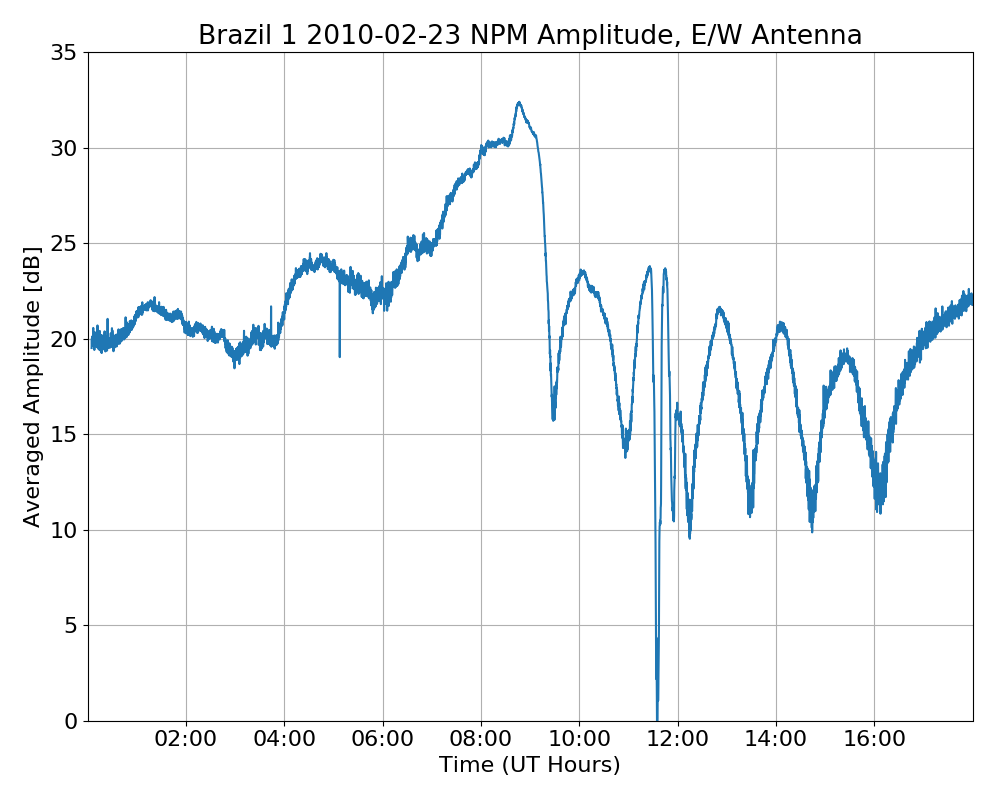

In [36]:
rcParams['figure.figsize']=10,8
rcParams['figure.autolayout'] = True
rcParams['font.size']=16

figure, (ax0)=subplots(1)    #, sharex=True, sharey=False)
ax0.plot(df0_integrated.index, 20*np.log10(df0_integrated.amp)-10)
#ax1.plot(df1_integrated.index, df1_integrated.phase - np.mean(df1_integrated.phase))
#ax1.plot(time1, data_phase - np.mean(data_phase))
ax0.set_ylabel('Averaged Amplitude [dB]')
#ax1.set_ylabel('Averaged Phase [Degrees]')
ax0.set_xlabel('Time (UT Hours)')
#ax1.set_xlabel('Time (UT Hours)')
ax0.xaxis.set_major_formatter(DateFormatter('%H:%M'))
#ax1.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax0.set_xlim(str(startdate0)[0:10]+' 00:00:01',str(startdate0)[0:10]+' 17:59:59')
ax0.set_ylim(0,35)
ax0.grid(True)


if adc_channel0 == 0:
    ax0.set_title(str("".join(map(chr,station_name0)))+' '+ str(startdate0)[0:10]+' '+ str(callsign0) + ' Amplitude, N/S Antenna')
elif adc_channel0 == 1:
    ax0.set_title(str("".join(map(chr,station_name0)))+' '+ str(startdate0)[0:10]+' '+ str(callsign0) + ' Amplitude, E/W Antenna')
else:
    ax0.set_title(str("".join(map(chr,station_name0)))+' '+ str(startdate0)[0:10]+' '+ str(callsign0) + ' Amplitude')
    
#if adc_channel1 == 0:
#    ax1.set_title(str("".join(map(chr,station_name1)))+' '+ str(startdate1)[0:10]+' '+ str(callsign1) + ' Phase, N/S Antenna')
#elif adc_channel1 == 1:
#    ax1.set_title(str("".join(map(chr,station_name1)))+' '+ str(startdate1)[0:10]+' '+ str(callsign1) + ' Phase, E/W Antenna')
#else:
#    ax1.set_title(str("".join(map(chr,station_name1)))+' '+ str(startdate1)[0:10]+' '+ str(callsign1) + ' Phase')

### Saving the figure

In [ ]:
savefig('D:/Documentos/Dropbox/matlab_emilia/'+str(callsign0)+'-'+str(startdate0)[0:10]+'.png', format='png')